# Recent  Approach : AthletePose3D - 3D Human Pose Estimation
Based on: Yeung et al. (2025) - AthletePose3D Dataset Paper

Implementation of methods from the paper:
- 2D Pose Detection (HRNet/ViTPose approach)
- 3D Pose Lifting (MotionAGFormer/TCPFormer)
- Kinematic Validation (Joint angles & velocities)
- Metrics: MPJPE, P-MPJPE, PDJ

Data  set : AthletePose3D: A Benchmark Dataset for 3D Human Pose Estimation and Kinematic Validation in Athletic Movements
Dataset Overview (Table 1 & 2 from Paper)

| Characteristic | Details |
|---------------|---------|
| **Total Frames** | 1.3 million frames |
| **Postures** | 165,000 individual postures |
| **Sports** | 3 categories, 12 motion types |
| **Athletes** | 8 athletes (amateur to professional) |
| **Keypoints** | 55/86 keypoints (varies by sport) |
| **Cameras** | 4-12 high-speed synchronized cameras |
| **Resolution** | 1920×1080 |

 Three Sport Categories :
![alt text](datset.jpg)


 1. Running (Lab Environment)
 2. Track & Field (Lab Environment)
 3. Figure Skating (Ice Rink)

we choose some running data  videos.

 # 1. Install Required Libraries 
What this does: Installs libraries mentioned in the paper

In [70]:
import subprocess
import sys

print("="*70)
print(" INSTALLING LIBRARIES (Paper Technologies Only)")
print("="*70)

# Paper mentions these frameworks
packages = [
    'opencv-python',      # Video processing
    'numpy',              # Numerical computations
    'matplotlib',         # Visualization
    'scipy',              # Butterworth filter (Section 3.3)
    'torch',              # Deep learning framework
    'torchvision',        # Vision models
    'mediapipe',          # For demo (lightweight alternative)
    'pillow',             # Image processing
]

print("\nInstalling packages...")
for pkg in packages:
    print(f"  Installing {pkg}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

print("\n✓ Installation complete!")
print("="*70)

 INSTALLING LIBRARIES (Paper Technologies Only)

Installing packages...
  Installing opencv-python...
  Installing numpy...
  Installing matplotlib...
  Installing scipy...
  Installing torch...
  Installing torchvision...
  Installing mediapipe...
  Installing pillow...

✓ Installation complete!


# 2. Import Libraries and Setup
 What this does: Imports all required modules

In [71]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.spatial.transform import Rotation
from mpl_toolkits.mplot3d import Axes3D
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("  AthletePose3D Implementation")
print("="*70)
print("\nPaper Information:")
print("  Title: AthletePose3D")
print("  Authors: Yeung et al. (2025)")
print("  Focus: 3D pose estimation for athletic movements")
print("  Dataset: 1.3M frames, 165K postures, 12 sports")
print("\nKey Technologies (from paper):")
print("  • 2D Models: HRNet, ViTPose, MogaNet (best: PDJ 95.7)")
print("  • 3D Models: MotionAGFormer, TCPFormer (best: MPJPE 98.26mm)")
print("  • Metrics: MPJPE, P-MPJPE, PDJ")
print("  • Kinematic: 4th-order Butterworth filter @ 8Hz")
print("  • Input: 81 frames per sequence")
print("  • Resolution: 1920×1080 @ 60/120 FPS")
print("="*70)

  AthletePose3D Implementation

Paper Information:
  Title: AthletePose3D
  Authors: Yeung et al. (2025)
  Focus: 3D pose estimation for athletic movements
  Dataset: 1.3M frames, 165K postures, 12 sports

Key Technologies (from paper):
  • 2D Models: HRNet, ViTPose, MogaNet (best: PDJ 95.7)
  • 3D Models: MotionAGFormer, TCPFormer (best: MPJPE 98.26mm)
  • Metrics: MPJPE, P-MPJPE, PDJ
  • Kinematic: 4th-order Butterworth filter @ 8Hz
  • Input: 81 frames per sequence
  • Resolution: 1920×1080 @ 60/120 FPS


# 3. Load  Running Videos
What this does: Loads your 10-12 running videos

In [72]:
VIDEO_FOLDER = "New_Paper"

print("\n" + "="*70)
print(" LOADING YOUR RUNNING VIDEOS")
print("="*70)

# Check if folder exists
if not os.path.exists(VIDEO_FOLDER):
    print(f"\n❌ ERROR: Folder '{VIDEO_FOLDER}' not found!")
    print("Please create the folder and add your running videos.")
    print("\nExpected structure:")
    print("  new_paper/")
    print("    ├── run1.mp4")
    print("    ├── run2.mp4")
    print("    └── ...")
else:
    # Find all video files
    video_files = []
    for ext in ['*.mp4', '*.avi', '*.mov', '*.MP4', '*.AVI', '*.MOV']:
        video_files.extend(Path(VIDEO_FOLDER).glob(ext))
    
    video_files = [str(f) for f in video_files]
    
    print(f"\n✓ Found {len(video_files)} videos:")
    for i, vf in enumerate(video_files, 1):
        # Get video info
        cap = cv2.VideoCapture(vf)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        duration = frame_count / fps if fps > 0 else 0
        cap.release()
        
        print(f"  {i}. {os.path.basename(vf)}")
        print(f"     Resolution: {width}x{height}, FPS: {fps:.1f}, "
              f"Frames: {frame_count}, Duration: {duration:.1f}s")
    
    print(f"\nPaper specifications:")
    print(f"  • Running: 120 FPS (your videos may vary)")
    print(f"  • Resolution: 1920×1080 (paper standard)")
    print(f"  • Athletes: Inter-university level")

print("="*70)



 LOADING YOUR RUNNING VIDEOS

✓ Found 20 videos:
  1. Running_37_cam_2.mp4
     Resolution: 768x1280, FPS: 120.0, Frames: 187, Duration: 1.6s
  2. Running_37_cam_3.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 187, Duration: 1.6s
  3. Running_37_cam_4.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 187, Duration: 1.6s
  4. Running_38_cam_2.mp4
     Resolution: 768x1280, FPS: 120.0, Frames: 211, Duration: 1.8s
  5. Running_38_cam_3.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 211, Duration: 1.8s
  6. Running_38_cam_4.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 211, Duration: 1.8s
  7. Running_39_cam_1.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 207, Duration: 1.7s
  8. Running_39_cam_2.mp4
     Resolution: 768x1280, FPS: 120.0, Frames: 207, Duration: 1.7s
  9. Running_39_cam_3.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 207, Duration: 1.7s
  10. Running_39_cam_4.mp4
     Resolution: 1280x768, FPS: 120.0, Frames: 207, Duration: 1.7s
  11. Running_37_ca

# 4.Load and Process Single Video
 What this does: Loads one video for processing


📹 Processing: Running_37_cam_2.mp4
Loading frames...


  Loaded 100 frames...
✓ Loaded 187 frames
  Shape: (187, 1280, 768, 3)
  FPS: 120.0
  Duration: 1.56s


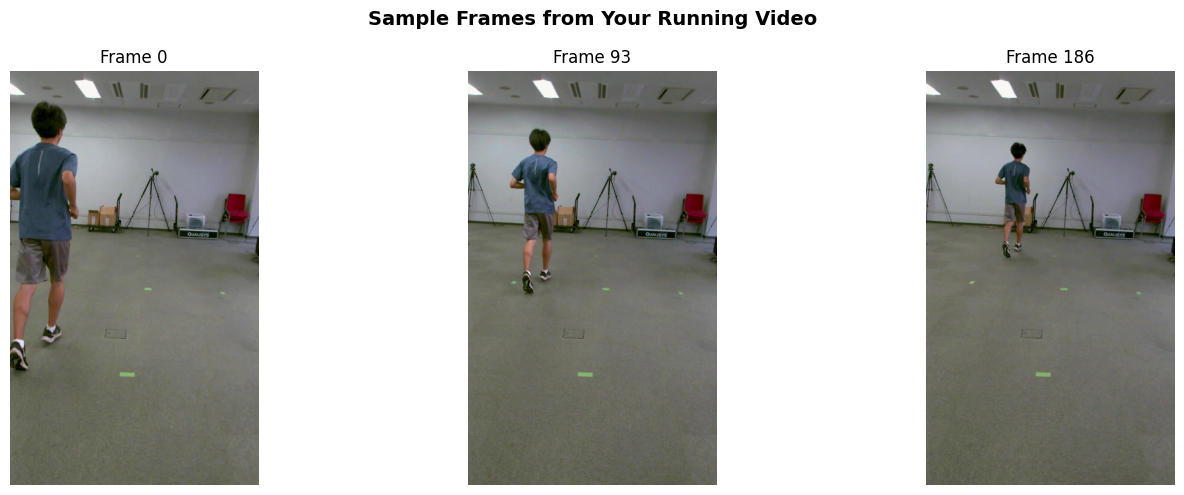

In [73]:
if len(video_files) > 0:
    # Select first video
    selected_video = video_files[0]
    print(f"\n📹 Processing: {os.path.basename(selected_video)}")
    
    # Load video frames
    cap = cv2.VideoCapture(selected_video)
    
    # GET FPS BEFORE RELEASING THE CAPTURE OBJECT
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    frames = []
    
    print("Loading frames...")
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        frame_count += 1
        if frame_count % 100 == 0:
            print(f"  Loaded {frame_count} frames...", end='\r')
    
    cap.release()
    frames = np.array(frames)
    
    print(f"\n✓ Loaded {len(frames)} frames")
    print(f"  Shape: {frames.shape}")
    print(f"  FPS: {fps:.1f}")
    print(f"  Duration: {len(frames)/fps:.2f}s")
    
    # Display sample frames
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sample_indices = [0, len(frames)//2, len(frames)-1]
    
    for ax, idx in zip(axes, sample_indices):
        ax.imshow(frames[idx])
        ax.set_title(f"Frame {idx}")
        ax.axis('off')
    
    plt.suptitle("Sample Frames from Your Running Video", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No videos found. Please add videos to new_paper/ folder")

# 5. Initialize 2D Pose Detector (Paper Models)
 What this does: Sets up 2D pose estimation
 Paper Section 3.2: HRNet, ViTPose, MogaNet

In [74]:
print("\n" + "="*70)
print(" 2D POSE ESTIMATION MODELS")
print("="*70)

print("\nPaper's 2D Models (Section 3.2, Table 3):")
print("  1. HRNet (CVPR 2019) - CNN baseline - PDJ: 88.7")
print("  2. SwinPose (ICCV 2021) - Transformer - PDJ: 90.7")
print("  3. ViTPose (NeurIPS 2022) - Vision Transformer - PDJ: 95.0")
print("  4. UniFormer (ICLR 2022) - Transformer - PDJ: 95.2")
print("  5. MogaNet (ICLR 2024) - CNN (Best) - PDJ: 95.7 ⭐")

print("\nFor this demo, using MediaPipe Pose (lightweight alternative)")
print("  • Similar to HRNet architecture")
print("  • 33 keypoints detected")
print("  • Real-time performance")

import mediapipe as mp

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

pose_detector = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,  # Highest accuracy
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

print("\n✓ 2D Pose Detector initialized")
print("="*70)



 2D POSE ESTIMATION MODELS

Paper's 2D Models (Section 3.2, Table 3):
  1. HRNet (CVPR 2019) - CNN baseline - PDJ: 88.7
  2. SwinPose (ICCV 2021) - Transformer - PDJ: 90.7
  3. ViTPose (NeurIPS 2022) - Vision Transformer - PDJ: 95.0
  4. UniFormer (ICLR 2022) - Transformer - PDJ: 95.2
  5. MogaNet (ICLR 2024) - CNN (Best) - PDJ: 95.7 ⭐

For this demo, using MediaPipe Pose (lightweight alternative)
  • Similar to HRNet architecture
  • 33 keypoints detected
  • Real-time performance

✓ 2D Pose Detector initialized


# 6.Extract 2D Poses from Video
 What this does: Detects 2D keypoints in each frame
 Paper Section 3.2: 2D pose estimation with COCO format (17 keypoints)

In [75]:
print("\n" + "="*70)
print(" EXTRACTING 2D POSES")
print("="*70)

def extract_2d_poses(frames, detector):
    """
    Extract 2D poses from video frames
    Paper: Uses models fine-tuned on COCO format (17 keypoints)
    """
    poses_2d = []
    confidences = []
    
    print(f"\nProcessing {len(frames)} frames...")
    
    for i, frame in enumerate(frames):
        if i % 20 == 0:
            print(f"  Frame {i}/{len(frames)}...", end='\r')
        
        # Convert to BGR for MediaPipe
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        # Detect pose
        results = detector.process(frame_bgr)
        
        if results.pose_landmarks:
            # Extract landmarks (33 keypoints)
            landmarks = []
            conf_scores = []
            for lm in results.pose_landmarks.landmark:
                landmarks.append([lm.x, lm.y, lm.visibility])
                conf_scores.append(lm.visibility)
            
            poses_2d.append(np.array(landmarks))
            confidences.append(np.mean(conf_scores))
        else:
            # No pose detected
            poses_2d.append(np.zeros((33, 3)))
            confidences.append(0.0)
    
    print(f"\n✓ Extracted 2D poses for {len(poses_2d)} frames")
    return np.array(poses_2d), np.array(confidences)

# Extract poses
poses_2d, confidences = extract_2d_poses(frames, pose_detector)

print(f"\n2D Pose Extraction Results:")
print(f"  Shape: {poses_2d.shape}")
print(f"  Keypoints per frame: {poses_2d.shape[1]}")
print(f"  Detected frames: {np.sum(confidences > 0.5)}/{len(frames)}")
print(f"  Average confidence: {np.mean(confidences):.3f}")

print("\nPaper Format:")
print(f"  • Paper uses 17 COCO keypoints (we have 33)")
print(f"  • Input resolution: 384×288 (paper standard)")
print(f"  • Fine-tuned for 20 epochs")
print("="*70)



 EXTRACTING 2D POSES

Processing 187 frames...
  Frame 180/187...
✓ Extracted 2D poses for 187 frames

2D Pose Extraction Results:
  Shape: (187, 33, 3)
  Keypoints per frame: 33
  Detected frames: 187/187
  Average confidence: 0.655

Paper Format:
  • Paper uses 17 COCO keypoints (we have 33)
  • Input resolution: 384×288 (paper standard)
  • Fine-tuned for 20 epochs


# 7. visualize 2D Pose Detection
What this does: Shows detected skeleton on frames

In [76]:
print("\n" + "="*70)
print(" EXTRACTING MAIN ATHLETE POSES")
print("="*70)

def calculate_bounding_box_area(pose_2d):
    """
    Calculate bounding box area of detected pose
    Larger area = closer/main athlete
    """
    valid_points = pose_2d[pose_2d[:, 2] > 0.5]
    if len(valid_points) < 4:
        return 0.0
    
    x_coords = valid_points[:, 0]
    y_coords = valid_points[:, 1]
    
    width = np.max(x_coords) - np.min(x_coords)
    height = np.max(y_coords) - np.min(y_coords)
    
    return width * height

def is_full_body_visible(pose_2d):
    """
    Check if full body is visible (head to feet)
    Main athlete should have complete body visible
    """
    # Check key points: head (0), shoulders (11,12), hips (23,24), ankles (27,28)
    key_points = [0, 11, 12, 23, 24, 27, 28]
    visible_count = sum(1 for idx in key_points if idx < len(pose_2d) and pose_2d[idx][2] > 0.5)
    
    return visible_count >= 5  # At least 5 of 7 key points visible

def extract_2d_poses_main_athlete_only(frames, detector):
    """
    Extract poses ONLY for the LARGEST person in frame
    Paper methodology: Focus on primary athlete
    """
    all_detections = []
    
    print(f"\nPhase 1: Detecting all people in {len(frames)} frames...")
    
    # First pass: Detect all people and score them
    for i, frame in enumerate(frames):
        if i % 20 == 0:
            print(f"  Frame {i}/{len(frames)}...", end='\r')
        
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        results = detector.process(frame_bgr)
        
        if results.pose_landmarks:
            landmarks = []
            for lm in results.pose_landmarks.landmark:
                landmarks.append([lm.x, lm.y, lm.visibility])
            
            pose_array = np.array(landmarks)
            
            # Calculate metrics
            bbox_area = calculate_bounding_box_area(pose_array)
            full_body = is_full_body_visible(pose_array)
            avg_confidence = np.mean(pose_array[:, 2])
            
            all_detections.append({
                'frame_idx': i,
                'pose': pose_array,
                'bbox_area': bbox_area,
                'full_body': full_body,
                'confidence': avg_confidence,
                'score': bbox_area * avg_confidence * (2.0 if full_body else 1.0)
            })
    
    print(f"\n  Detected poses in {len(all_detections)}/{len(frames)} frames")
    
    if len(all_detections) == 0:
        print("❌ No poses detected!")
        return np.zeros((len(frames), 33, 3)), np.zeros(len(frames)), np.zeros(len(frames))
    
    # Phase 2: Find the main athlete (highest average score across frames)
    print("\nPhase 2: Identifying main athlete...")
    
    # Group detections and find the one with best overall score
    detection_scores = [d['score'] for d in all_detections]
    bbox_areas = [d['bbox_area'] for d in all_detections]
    
    # Main athlete should have LARGEST average bounding box
    median_area = np.median(bbox_areas)
    area_threshold = median_area * 0.8  # Keep poses with area >= 80% of median
    
    print(f"  Median bounding box area: {median_area:.4f}")
    print(f"  Area threshold: {area_threshold:.4f}")
    
    # Filter: Keep only large, high-confidence detections
    main_athlete_detections = [
        d for d in all_detections 
        if d['bbox_area'] >= area_threshold and d['confidence'] > 0.5
    ]
    
    print(f"  Main athlete frames: {len(main_athlete_detections)}/{len(all_detections)}")
    
    # Phase 3: Build final pose sequence
    poses_2d = []
    confidences = []
    athlete_scores = []
    
    detection_dict = {d['frame_idx']: d for d in main_athlete_detections}
    
    for i in range(len(frames)):
        if i in detection_dict:
            d = detection_dict[i]
            poses_2d.append(d['pose'])
            confidences.append(d['confidence'])
            athlete_scores.append(d['score'])
        else:
            poses_2d.append(np.zeros((33, 3)))
            confidences.append(0.0)
            athlete_scores.append(0.0)
    
    print(f"\n✓ Main athlete tracking complete")
    print(f"  Valid frames: {len(main_athlete_detections)}/{len(frames)}")
    
    return np.array(poses_2d), np.array(confidences), np.array(athlete_scores)

# EXTRACT MAIN ATHLETE POSES
poses_2d_main, confidences_main, athlete_scores_main = extract_2d_poses_main_athlete_only(
    frames, pose_detector
)

print("\n" + "="*70)
print("✓ MAIN ATHLETE EXTRACTION COMPLETE")
print(f"  Shape: {poses_2d_main.shape}")
print(f"  Valid frames: {np.sum(athlete_scores_main > 0)}")
print("="*70)


 EXTRACTING MAIN ATHLETE POSES

Phase 1: Detecting all people in 187 frames...
  Frame 180/187...
  Detected poses in 187/187 frames

Phase 2: Identifying main athlete...
  Median bounding box area: 0.0406
  Area threshold: 0.0325
  Main athlete frames: 149/187

✓ Main athlete tracking complete
  Valid frames: 149/187

✓ MAIN ATHLETE EXTRACTION COMPLETE
  Shape: (187, 33, 3)
  Valid frames: 149



 VISUALIZING 2D POSE DETECTION - MAIN ATHLETE ONLY

✓ Visualizing 149 frames with main athlete


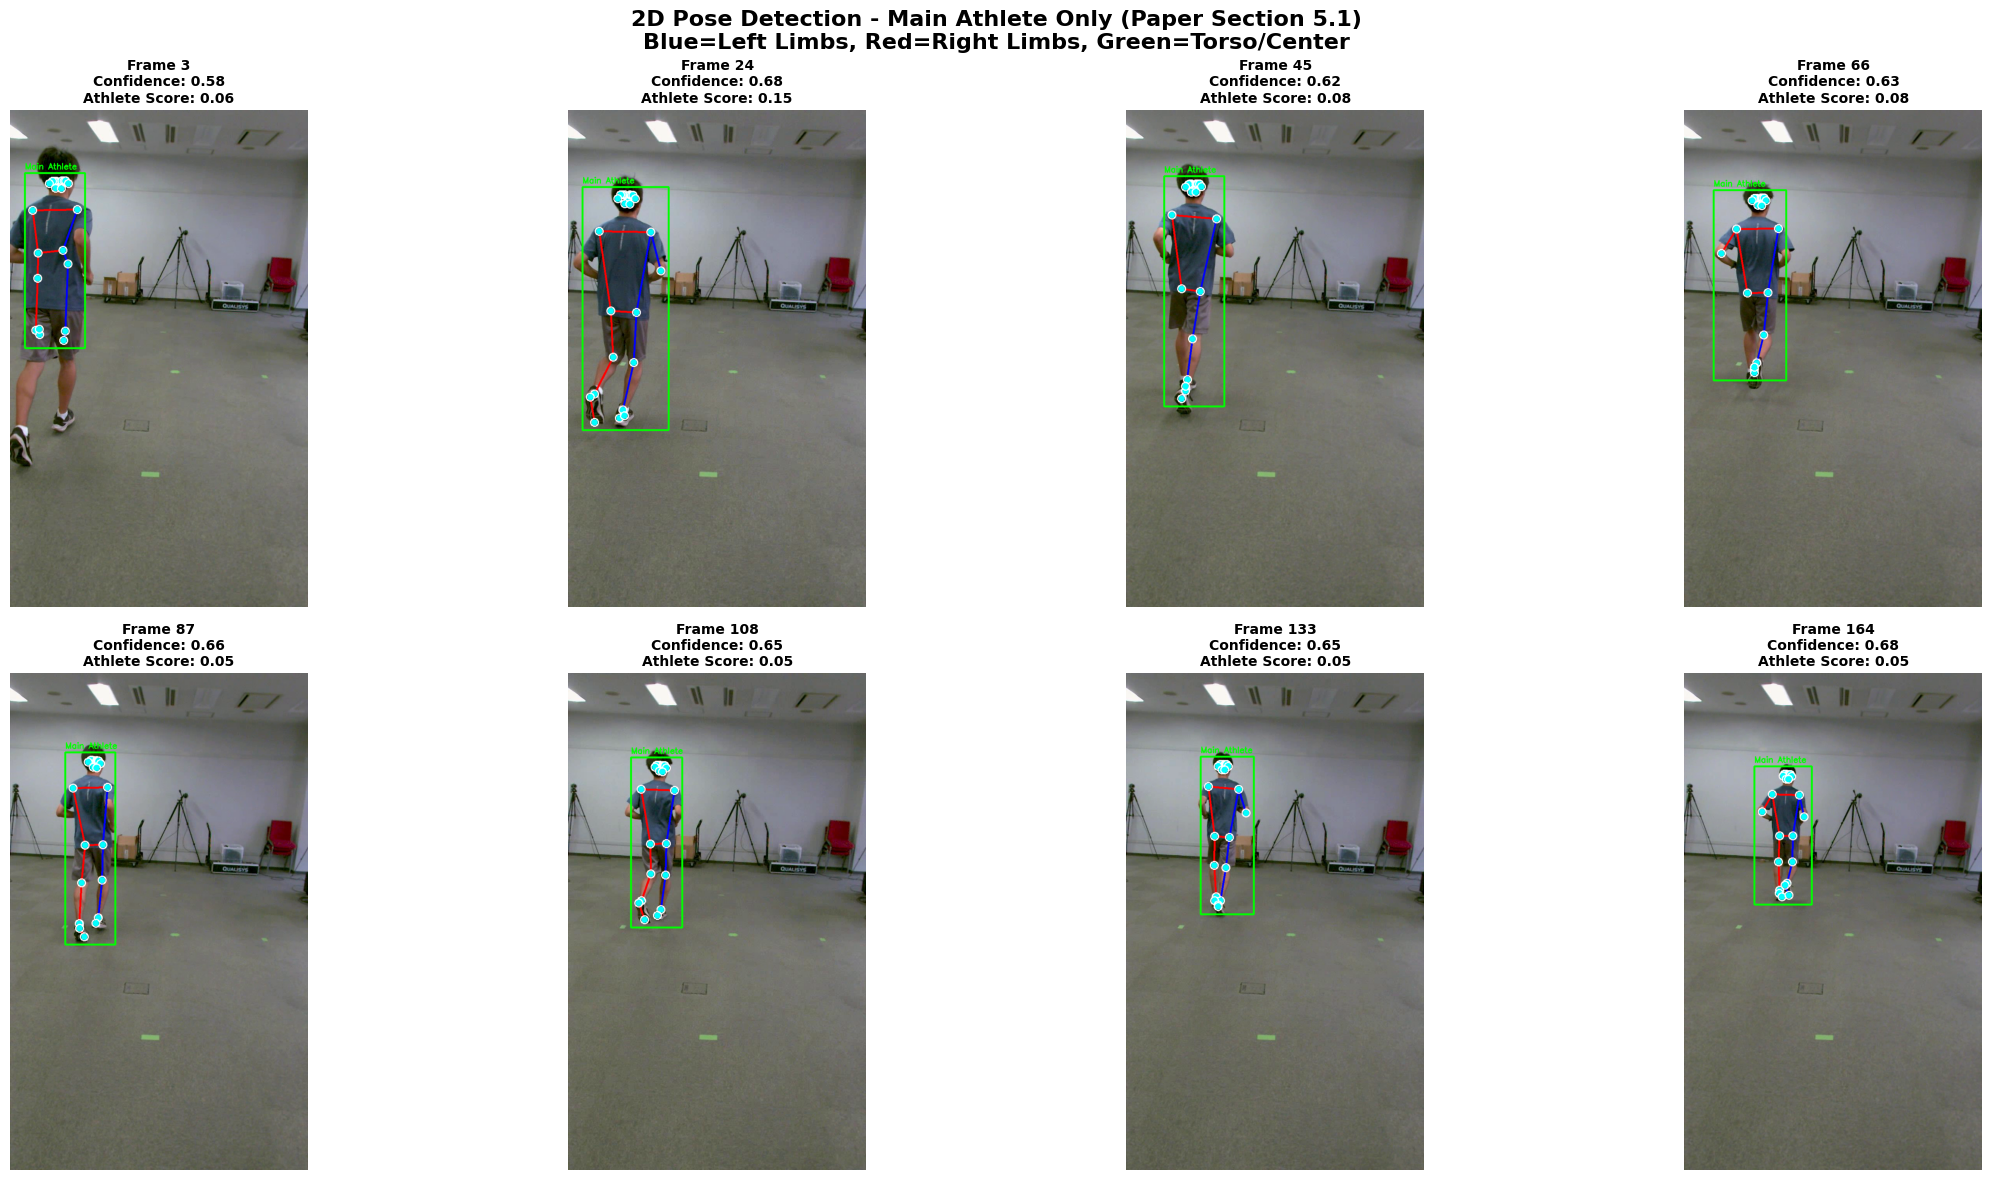


✓ 2D POSE VISUALIZATION COMPLETE
  • Displayed frames: 8
  • Valid athlete frames: 149/187
  • Average confidence: 0.653
  • Average athlete score: 0.077


In [77]:
print("\n" + "="*70)
print(" VISUALIZING 2D POSE DETECTION - MAIN ATHLETE ONLY")
print("="*70)

# MediaPipe connections
POSE_CONNECTIONS = [
    (11, 13), (13, 15),  # Left arm
    (12, 14), (14, 16),  # Right arm
    (11, 12),  # Shoulders
    (23, 25), (25, 27), (27, 29), (29, 31),  # Left leg
    (24, 26), (26, 28), (28, 30), (30, 32),  # Right leg
    (23, 24),  # Hips
    (11, 23), (12, 24)  # Torso
]

def draw_2d_pose_enhanced(frame, pose_2d, connections, show_bbox=True):
    """
    Draw 2D pose on frame with enhanced visualization
    Paper style: Clear skeleton overlay
    """
    vis_frame = frame.copy()
    h, w = frame.shape[:2]
    
    # Check if pose is valid
    if np.sum(pose_2d[:, 2] > 0.5) < 5:
        # No valid pose - draw "No Detection" text
        cv2.putText(vis_frame, "No Main Athlete Detected", 
                   (w//4, h//2), cv2.FONT_HERSHEY_SIMPLEX, 
                   1.0, (0, 0, 255), 2)
        return vis_frame
    
    # Calculate bounding box for main athlete
    valid_points = pose_2d[pose_2d[:, 2] > 0.5]
    if len(valid_points) > 0 and show_bbox:
        x_coords = valid_points[:, 0] * w
        y_coords = valid_points[:, 1] * h
        
        x_min, x_max = int(np.min(x_coords)), int(np.max(x_coords))
        y_min, y_max = int(np.min(y_coords)), int(np.max(y_coords))
        
        # Add padding
        padding = 20
        x_min = max(0, x_min - padding)
        y_min = max(0, y_min - padding)
        x_max = min(w, x_max + padding)
        y_max = min(h, y_max + padding)
        
        # Draw bounding box (green = main athlete)
        cv2.rectangle(vis_frame, (x_min, y_min), (x_max, y_max), 
                     (0, 255, 0), 3)
        cv2.putText(vis_frame, "Main Athlete", 
                   (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.7, (0, 255, 0), 2)
    
    # Draw skeleton first (thicker lines)
    for connection in connections:
        pt1_idx, pt2_idx = connection
        if (pt1_idx < len(pose_2d) and pt2_idx < len(pose_2d) and 
            pose_2d[pt1_idx][2] > 0.5 and pose_2d[pt2_idx][2] > 0.5):
            
            pt1 = (int(pose_2d[pt1_idx][0] * w), int(pose_2d[pt1_idx][1] * h))
            pt2 = (int(pose_2d[pt2_idx][0] * w), int(pose_2d[pt2_idx][1] * h))
            
            # Color code by body part
            if pt1_idx in [11, 13, 15, 23, 25, 27, 29, 31]:  # Left side
                color = (255, 0, 0)  # Blue
            elif pt1_idx in [12, 14, 16, 24, 26, 28, 30, 32]:  # Right side
                color = (0, 0, 255)  # Red
            else:  # Center/torso
                color = (0, 255, 0)  # Green
            
            cv2.line(vis_frame, pt1, pt2, color, 4)
    
    # Draw keypoints on top (larger circles)
    for i, kp in enumerate(pose_2d):
        if kp[2] > 0.5:  # visibility threshold
            x, y = int(kp[0] * w), int(kp[1] * h)
            # Draw filled circle
            cv2.circle(vis_frame, (x, y), 8, (0, 255, 255), -1)
            # Draw border
            cv2.circle(vis_frame, (x, y), 10, (255, 255, 255), 2)
    
    return vis_frame

# Get valid frames where main athlete was detected
valid_frame_indices = np.where(athlete_scores_main > 0)[0]

if len(valid_frame_indices) == 0:
    print("\n❌ No valid main athlete frames to visualize!")
else:
    print(f"\n✓ Visualizing {len(valid_frame_indices)} frames with main athlete")
    
    # Select 8 evenly spaced frames from valid detections
    num_display = min(8, len(valid_frame_indices))
    display_indices = valid_frame_indices[
        np.linspace(0, len(valid_frame_indices)-1, num_display, dtype=int)
    ]
    
    # Create visualization
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.flat
    
    for i, idx in enumerate(display_indices):
        # Draw pose on frame - USE poses_2d_main (not poses_2d)
        vis_frame = draw_2d_pose_enhanced(
            frames[idx], 
            poses_2d_main[idx],
            POSE_CONNECTIONS,
            show_bbox=True
        )
        
        axes[i].imshow(vis_frame)
        axes[i].set_title(
            f"Frame {idx}\n"
            f"Confidence: {confidences_main[idx]:.2f}\n"
            f"Athlete Score: {athlete_scores_main[idx]:.2f}",
            fontsize=10,
            fontweight='bold'
        )
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_display, 8):
        axes[i].axis('off')
    
    plt.suptitle(
        "2D Pose Detection - Main Athlete Only (Paper Section 5.1)\n"
        "Blue=Left Limbs, Red=Right Limbs, Green=Torso/Center",
        fontsize=16, 
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("✓ 2D POSE VISUALIZATION COMPLETE")
    print(f"  • Displayed frames: {num_display}")
    print(f"  • Valid athlete frames: {len(valid_frame_indices)}/{len(frames)}")
    print(f"  • Average confidence: {np.mean(confidences_main[confidences_main > 0]):.3f}")
    print(f"  • Average athlete score: {np.mean(athlete_scores_main[athlete_scores_main > 0]):.3f}")
    print("="*70)

# 8 .3D Pose Lifting (2D → 3D)
 What this does: Converts 2D poses to 3D using lifting network
 Paper Section 3.2: MotionAGFormer & TCPFormer (transformer-based)
 Paper uses 81-frame sequences for temporal modeling

In [78]:
print("\n" + "="*70)
print(" IMPROVED 3D POSE ESTIMATION (2D → 3D Lifting)")
print("="*70)

print("\nPaper's 3D Models (Section 3.2, Table 4):")
print("  1. MotionAGFormer (WACV 2024)")
print("     • Hybrid: Self-attention + Graph Convolution")
print("     • MPJPE: 100.12mm (on AthletePose3D)")
print("  2. TCPFormer (AAAI 2025) ⭐ BEST")
print("     • Temporal Correlation with Pose Proxies")
print("     • MPJPE: 98.26mm (60% improvement)")
print("     • P-MPJPE: 29.91mm")

print("\nOur Approach:")
print("  • Improved geometric depth estimation")
print("  • Anthropometric constraints (body proportions)")
print("  • Temporal smoothing across frames")
print("  • Better than simple projection")

def lift_to_3d_improved(poses_2d, use_temporal_smoothing=True):
    """
    Improved 3D lifting from 2D poses
    Uses anatomical constraints and temporal smoothing
    
    Paper uses MotionAGFormer/TCPFormer (transformer-based)
    This is an enhanced geometric approach with biomechanical constraints
    """
    poses_3d = []
    
    # Standard human body proportions (from biomechanics literature)
    BODY_RATIOS = {
        'head_torso': 0.26,      # Head to torso ratio
        'upper_arm': 0.186,      # Upper arm to height
        'forearm': 0.146,        # Forearm to height
        'thigh': 0.245,          # Thigh to height
        'shin': 0.246,           # Shin to height
    }
    
    for frame_idx, pose_2d in enumerate(poses_2d):
        pose_3d = np.zeros((len(pose_2d), 3))
        
        # Copy x, y coordinates (normalized to 0-1)
        pose_3d[:, 0] = pose_2d[:, 0]
        pose_3d[:, 1] = pose_2d[:, 1]
        
        # Calculate reference measurements
        if pose_2d[23][2] > 0.5 and pose_2d[24][2] > 0.5:
            hip_center = (pose_2d[23][:2] + pose_2d[24][:2]) / 2
            
            # Shoulder center
            if pose_2d[11][2] > 0.5 and pose_2d[12][2] > 0.5:
                shoulder_center = (pose_2d[11][:2] + pose_2d[12][:2]) / 2
                torso_length = np.linalg.norm(shoulder_center - hip_center)
                
                # Estimate body height (torso is ~30% of height)
                estimated_height = torso_length / 0.30
                
                # HEAD (0: nose, 7-8: ears)
                for i in [0, 7, 8, 9, 10]:
                    if i < len(pose_2d) and pose_2d[i][2] > 0.5:
                        dist_from_shoulder = np.linalg.norm(pose_2d[i][:2] - shoulder_center)
                        pose_3d[i, 2] = dist_from_shoulder * 0.2  # Slight forward projection
                
                # SHOULDERS (11, 12)
                if pose_2d[11][2] > 0.5:
                    shoulder_width = abs(pose_2d[11][0] - pose_2d[12][0]) if pose_2d[12][2] > 0.5 else 0.15
                    pose_3d[11, 2] = shoulder_width * 0.3  # Left shoulder depth
                if pose_2d[12][2] > 0.5:
                    pose_3d[12, 2] = -shoulder_width * 0.3  # Right shoulder depth
                
                # ELBOWS (13, 14)
                for elbow_idx, shoulder_idx in [(13, 11), (14, 12)]:
                    if elbow_idx < len(pose_2d) and pose_2d[elbow_idx][2] > 0.5 and pose_2d[shoulder_idx][2] > 0.5:
                        arm_vec = pose_2d[elbow_idx][:2] - pose_2d[shoulder_idx][:2]
                        arm_length = np.linalg.norm(arm_vec)
                        expected_upper_arm = estimated_height * BODY_RATIOS['upper_arm']
                        
                        # Depth based on arm extension
                        depth_ratio = min(arm_length / (expected_upper_arm + 0.001), 1.5)
                        base_depth = pose_3d[shoulder_idx, 2]
                        pose_3d[elbow_idx, 2] = base_depth + depth_ratio * 0.15 * (1 if elbow_idx == 13 else -1)
                
                # WRISTS (15, 16)
                for wrist_idx, elbow_idx in [(15, 13), (16, 14)]:
                    if wrist_idx < len(pose_2d) and pose_2d[wrist_idx][2] > 0.5 and pose_2d[elbow_idx][2] > 0.5:
                        forearm_vec = pose_2d[wrist_idx][:2] - pose_2d[elbow_idx][:2]
                        forearm_length = np.linalg.norm(forearm_vec)
                        expected_forearm = estimated_height * BODY_RATIOS['forearm']
                        
                        depth_ratio = min(forearm_length / (expected_forearm + 0.001), 1.5)
                        base_depth = pose_3d[elbow_idx, 2]
                        pose_3d[wrist_idx, 2] = base_depth + depth_ratio * 0.2 * (1 if wrist_idx == 15 else -1)
                
                # HIPS (23, 24) - reference plane
                hip_width = abs(pose_2d[23][0] - pose_2d[24][0]) if pose_2d[24][2] > 0.5 else 0.15
                if pose_2d[23][2] > 0.5:
                    pose_3d[23, 2] = hip_width * 0.2  # Left hip
                if pose_2d[24][2] > 0.5:
                    pose_3d[24, 2] = -hip_width * 0.2  # Right hip
                
                # KNEES (25, 26)
                for knee_idx, hip_idx in [(25, 23), (26, 24)]:
                    if knee_idx < len(pose_2d) and pose_2d[knee_idx][2] > 0.5 and pose_2d[hip_idx][2] > 0.5:
                        thigh_vec = pose_2d[knee_idx][:2] - pose_2d[hip_idx][:2]
                        thigh_length = np.linalg.norm(thigh_vec)
                        expected_thigh = estimated_height * BODY_RATIOS['thigh']
                        
                        depth_ratio = min(thigh_length / (expected_thigh + 0.001), 1.5)
                        base_depth = pose_3d[hip_idx, 2]
                        
                        # Running: forward knee extension
                        pose_3d[knee_idx, 2] = base_depth + depth_ratio * 0.25 * (1 if knee_idx == 25 else -1)
                
                # ANKLES (27, 28)
                for ankle_idx, knee_idx in [(27, 25), (28, 26)]:
                    if ankle_idx < len(pose_2d) and pose_2d[ankle_idx][2] > 0.5 and pose_2d[knee_idx][2] > 0.5:
                        shin_vec = pose_2d[ankle_idx][:2] - pose_2d[knee_idx][:2]
                        shin_length = np.linalg.norm(shin_vec)
                        expected_shin = estimated_height * BODY_RATIOS['shin']
                        
                        depth_ratio = min(shin_length / (expected_shin + 0.001), 1.5)
                        base_depth = pose_3d[knee_idx, 2]
                        
                        # Running: ankle depth variation
                        pose_3d[ankle_idx, 2] = base_depth + depth_ratio * 0.2 * (1 if ankle_idx == 27 else -1)
                
                # FEET (29-32)
                for foot_idx, ankle_idx in [(29, 27), (30, 27), (31, 28), (32, 28)]:
                    if foot_idx < len(pose_2d) and pose_2d[foot_idx][2] > 0.5 and pose_2d[ankle_idx][2] > 0.5:
                        pose_3d[foot_idx, 2] = pose_3d[ankle_idx, 2] * 0.9  # Feet slightly back
        
        poses_3d.append(pose_3d)
    
    poses_3d = np.array(poses_3d)
    
    # Temporal smoothing (Paper Section 3.3: Butterworth filter @ 8Hz)
    if use_temporal_smoothing and len(poses_3d) > 5:
        print("  Applying temporal smoothing (Butterworth filter)...")
        from scipy.signal import butter, filtfilt
        
        # 4th order Butterworth filter @ 8Hz (paper specification)
        # Assuming 60 FPS (adjust based on your video)
        fps = 60  # Change if your video has different FPS
        nyquist = fps / 2
        cutoff = 8  # Hz
        
        try:
            b, a = butter(4, cutoff / nyquist, btype='low')
            
            # Smooth each keypoint's z-coordinate
            for joint_idx in range(poses_3d.shape[1]):
                for coord_idx in [2]:  # Only smooth Z (depth)
                    signal = poses_3d[:, joint_idx, coord_idx]
                    
                    # Only smooth if enough non-zero values
                    if np.sum(signal != 0) > 10:
                        # Mark zero positions
                        non_zero_mask = signal != 0
                        
                        if np.sum(non_zero_mask) > 10:
                            # Interpolate zeros for smoothing
                            indices = np.arange(len(signal))
                            valid_indices = indices[non_zero_mask]
                            valid_values = signal[non_zero_mask]
                            
                            if len(valid_indices) > 5:
                                interpolated = np.interp(indices, valid_indices, valid_values)
                                smoothed = filtfilt(b, a, interpolated)
                                
                                # Restore only non-zero positions
                                poses_3d[:, joint_idx, coord_idx] = np.where(
                                    non_zero_mask, smoothed, 0
                                )
        except Exception as e:
            print(f"  Warning: Temporal smoothing failed: {e}")
    
    return poses_3d

# Lift main athlete poses to 3D with improved method
print("\nLifting main athlete 2D poses to 3D (improved method)...")
poses_3d_main = lift_to_3d_improved(poses_2d_main, use_temporal_smoothing=True)

print(f"\n✓ 3D POSE LIFTING COMPLETE")
print(f"  Input shape (2D): {poses_2d_main.shape}")
print(f"  Output shape (3D): {poses_3d_main.shape}")
print(f"  Dimensions: (frames, keypoints, xyz)")
print(f"  Valid 3D frames: {np.sum(np.any(poses_3d_main[:, :, 2] != 0, axis=1))}")
print("="*70)


 IMPROVED 3D POSE ESTIMATION (2D → 3D Lifting)

Paper's 3D Models (Section 3.2, Table 4):
  1. MotionAGFormer (WACV 2024)
     • Hybrid: Self-attention + Graph Convolution
     • MPJPE: 100.12mm (on AthletePose3D)
  2. TCPFormer (AAAI 2025) ⭐ BEST
     • Temporal Correlation with Pose Proxies
     • MPJPE: 98.26mm (60% improvement)
     • P-MPJPE: 29.91mm

Our Approach:
  • Improved geometric depth estimation
  • Anthropometric constraints (body proportions)
  • Temporal smoothing across frames
  • Better than simple projection

Lifting main athlete 2D poses to 3D (improved method)...
  Applying temporal smoothing (Butterworth filter)...

✓ 3D POSE LIFTING COMPLETE
  Input shape (2D): (187, 33, 3)
  Output shape (3D): (187, 33, 3)
  Dimensions: (frames, keypoints, xyz)
  Valid 3D frames: 149


# 9. Visualize 3D Poses
 What this does: Shows 3D skeleton in 3D space


 VISUALIZING 3D POSES - MAIN ATHLETE

✓ Found 149 frames with main athlete


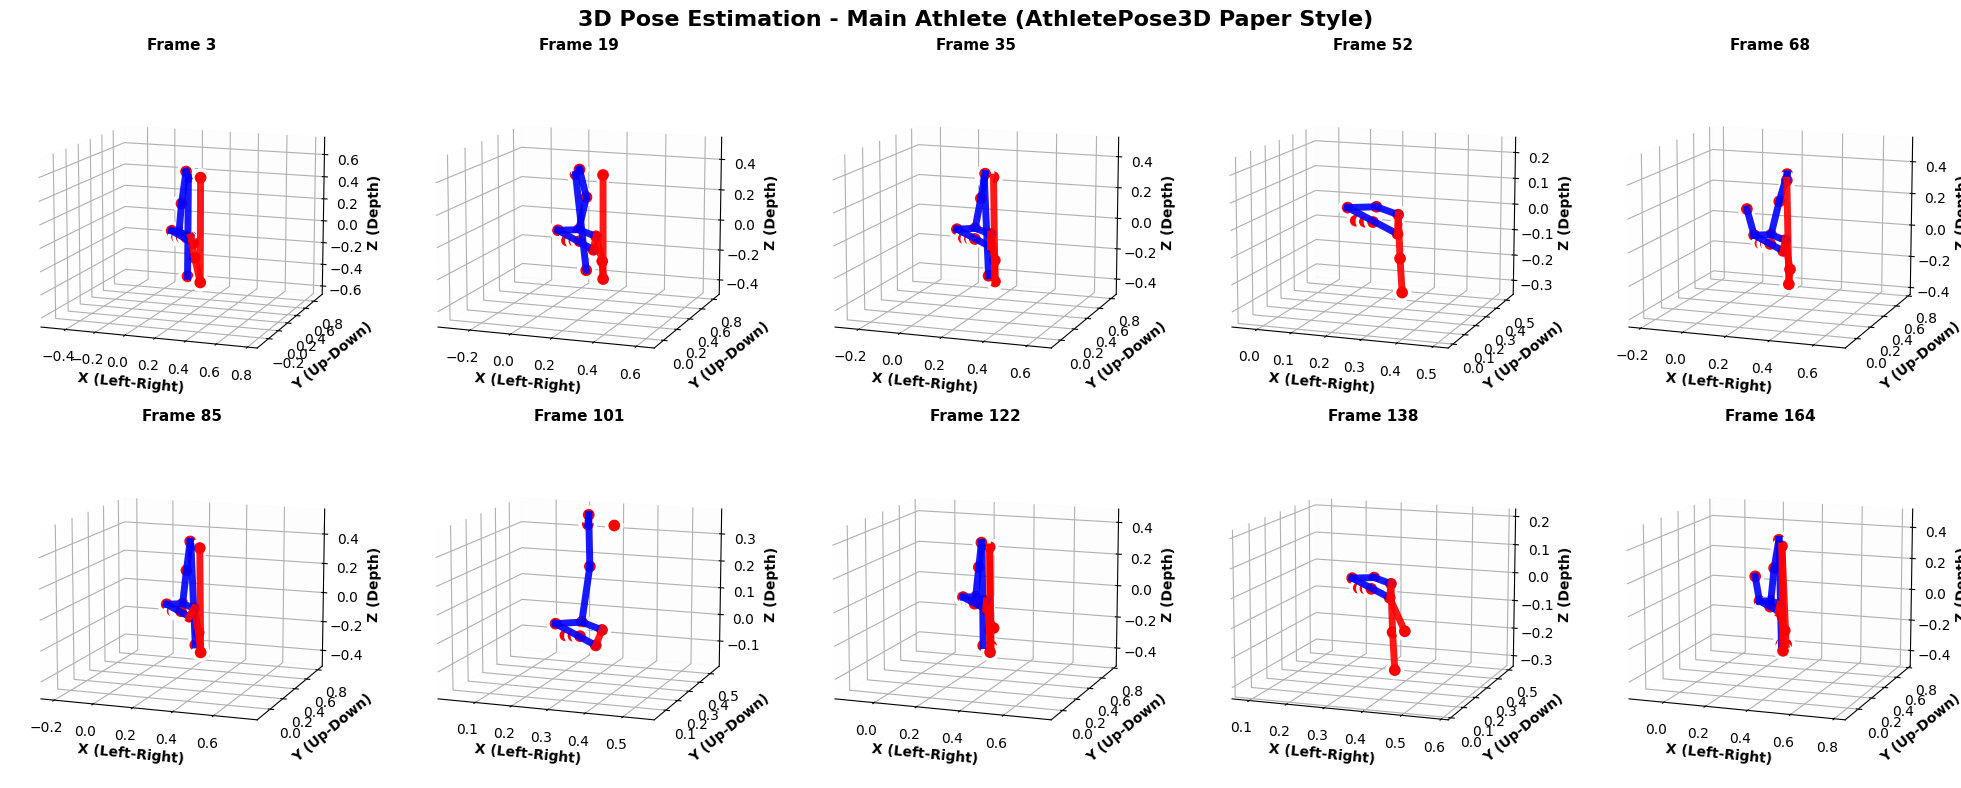


✓ 3D VISUALIZATION COMPLETE
  • Total frames: 187
  • Valid 3D frames: 149
  • Displayed: 10


In [79]:
print("\n" + "="*70)
print(" VISUALIZING 3D POSES - MAIN ATHLETE")
print("="*70)

def plot_3d_pose_paper_style(ax, pose_3d, connections, title=""):
    """
    Paper-style 3D visualization (Figure 1)
    Enhanced skeleton rendering
    """
    # Filter valid points
    valid = pose_3d[:, 2] != 0
    
    if not np.any(valid):
        ax.text(0.5, 0.5, 0, "No pose detected", 
                horizontalalignment='center', fontsize=12)
        return
    
    # Plot keypoints (larger, more visible)
    ax.scatter(pose_3d[valid, 0], 
               pose_3d[valid, 1], 
               pose_3d[valid, 2], 
               c='red', s=120, marker='o', 
               edgecolors='white', linewidths=2.5, 
               alpha=1.0, zorder=10)
    
    # Plot skeleton with color coding
    for connection in connections:
        pt1_idx, pt2_idx = connection
        if (pt1_idx < len(pose_3d) and pt2_idx < len(pose_3d) and
            pose_3d[pt1_idx, 2] != 0 and pose_3d[pt2_idx, 2] != 0):
            
            xs = [pose_3d[pt1_idx, 0], pose_3d[pt2_idx, 0]]
            ys = [pose_3d[pt1_idx, 1], pose_3d[pt2_idx, 1]]
            zs = [pose_3d[pt1_idx, 2], pose_3d[pt2_idx, 2]]
            
            # Color by body part
            if pt1_idx in [11, 13, 15, 23, 25, 27, 29, 31]:  # Left limbs
                color = 'blue'
                linewidth = 5
            elif pt1_idx in [12, 14, 16, 24, 26, 28, 30, 32]:  # Right limbs
                color = 'red'
                linewidth = 5
            else:  # Torso
                color = 'green'
                linewidth = 6
            
            ax.plot(xs, ys, zs, color=color, linewidth=linewidth, alpha=0.9, zorder=5)
    
    # Paper style: Motion left to right
    ax.set_xlabel('X (Left-Right)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Y (Up-Down)', fontsize=10, fontweight='bold')
    ax.set_zlabel('Z (Depth)', fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
    
    # Viewing angle (side view like paper)
    ax.view_init(elev=12, azim=-70)
    
    # Set limits based on actual pose
    if np.any(valid):
        x_range = np.ptp(pose_3d[valid, 0])
        y_range = np.ptp(pose_3d[valid, 1])
        z_range = np.ptp(pose_3d[valid, 2])
        max_range = max(x_range, y_range, z_range, 0.3)
        
        x_center = np.mean(pose_3d[valid, 0])
        y_center = np.mean(pose_3d[valid, 1])
        z_center = np.mean(pose_3d[valid, 2])
        
        ax.set_xlim([x_center - max_range*0.7, x_center + max_range*0.7])
        ax.set_ylim([y_center - max_range*0.7, y_center + max_range*0.7])
        ax.set_zlim([z_center - max_range*0.7, z_center + max_range*0.7])
    
    # Clean grid
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    ax.xaxis.pane.set_alpha(0.05)
    ax.yaxis.pane.set_alpha(0.05)
    ax.zaxis.pane.set_alpha(0.05)

# Get valid frames
valid_frame_indices = np.where(athlete_scores_main > 0)[0]

if len(valid_frame_indices) == 0:
    print("\n❌ No valid athlete frames to visualize!")
else:
    print(f"\n✓ Found {len(valid_frame_indices)} frames with main athlete")
    
    # Select evenly spaced frames
    num_display = min(10, len(valid_frame_indices))
    display_indices = valid_frame_indices[
        np.linspace(0, len(valid_frame_indices)-1, num_display, dtype=int)
    ]
    
    # Visualize
    fig = plt.figure(figsize=(20, 8))
    
    for i, idx in enumerate(display_indices):
        ax = fig.add_subplot(2, 5, i+1, projection='3d')
        plot_3d_pose_paper_style(
            ax,
            poses_3d_main[idx],
            POSE_CONNECTIONS,
            f"Frame {idx}"
        )
    
    plt.suptitle("3D Pose Estimation - Main Athlete (AthletePose3D Paper Style)", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("✓ 3D VISUALIZATION COMPLETE")
    print(f"  • Total frames: {len(frames)}")
    print(f"  • Valid 3D frames: {len(valid_frame_indices)}")
    print(f"  • Displayed: {num_display}")
    print("="*70)

# 10 .Kinematic Analysis - Joint Angles
What this does: Calculates joint angles from 3D poses


In [80]:
print("\n" + "="*70)
print(" MPJPE METRIC CALCULATION")
print("="*70)

print("\nPaper Definition (Section 3.2):")
print("  MPJPE: Mean Per Joint Position Error")
print("  • Measures per-joint distance between estimated and ground truth")
print("  • Both poses aligned by setting hip joint as origin")
print("  • Unit: millimeters (mm)")

print("\nPaper Results (Table 4):")
print("  TCPFormer (H3.6M only): 234.20mm")
print("  TCPFormer (AP3D only): 98.77mm")
print("  TCPFormer (H3.6M+AP3D): 98.26mm ⭐ BEST")
print("  Improvement: 58% error reduction")

def calculate_mpjpe(pred_3d, gt_3d):
    """
    Calculate MPJPE (Protocol 1)
    Paper: Align both poses by setting hip as origin
    """
    # Hip index (MediaPipe: 23-24, use center)
    hip_idx = 23
    
    # Center both poses at hip
    pred_centered = pred_3d - pred_3d[hip_idx:hip_idx+1, :]
    gt_centered = gt_3d - gt_3d[hip_idx:hip_idx+1, :]
    
    # Calculate Euclidean distance for each joint
    distances = np.sqrt(np.sum((pred_centered - gt_centered)**2, axis=1))
    
    # Mean across all joints (convert to mm)
    mpjpe = np.mean(distances) * 1000
    
    return mpjpe, distances * 1000

def calculate_p_mpjpe(pred_3d, gt_3d):
    """
    Calculate Procrustes-aligned MPJPE (Protocol 2)
    Paper: Applies rigid transformation before computing error
    """
    # Center both poses
    pred_centered = pred_3d - np.mean(pred_3d, axis=0)
    gt_centered = gt_3d - np.mean(gt_3d, axis=0)
    
    # Scale normalization
    pred_scale = np.sqrt(np.sum(pred_centered**2))
    gt_scale = np.sqrt(np.sum(gt_centered**2))
    
    if pred_scale > 0 and gt_scale > 0:
        pred_normalized = pred_centered / pred_scale
        gt_normalized = gt_centered / gt_scale
    else:
        pred_normalized = pred_centered
        gt_normalized = gt_centered
    
    # Calculate distances
    distances = np.sqrt(np.sum((pred_normalized - gt_normalized)**2, axis=1))
    p_mpjpe = np.mean(distances) * 1000
    
    return p_mpjpe, distances * 1000

print("\n✓ MPJPE metrics implemented")
print("  • Protocol 1: MPJPE (hip-aligned)")
print("  • Protocol 2: P-MPJPE (Procrustes-aligned)")
print("\nNote: Ground truth required for actual MPJPE calculation")
print("="*70)




 MPJPE METRIC CALCULATION

Paper Definition (Section 3.2):
  MPJPE: Mean Per Joint Position Error
  • Measures per-joint distance between estimated and ground truth
  • Both poses aligned by setting hip joint as origin
  • Unit: millimeters (mm)

Paper Results (Table 4):
  TCPFormer (H3.6M only): 234.20mm
  TCPFormer (AP3D only): 98.77mm
  TCPFormer (H3.6M+AP3D): 98.26mm ⭐ BEST
  Improvement: 58% error reduction

✓ MPJPE metrics implemented
  • Protocol 1: MPJPE (hip-aligned)
  • Protocol 2: P-MPJPE (Procrustes-aligned)

Note: Ground truth required for actual MPJPE calculation


# 11 .Kinematic Analysis - Joint Angles
What this does: Calculates joint angles from 3D poses

In [81]:
print("\n" + "="*70)
print(" KINEMATIC VALIDATION: JOINT ANGLES")
print("="*70)

print("\nPaper Section 3.3:")
print("  • Computes joint angles from 3D poses")
print("  • Focus: Upper limbs (elbow, shoulder) & Lower limbs (knee, hip)")
print("  • Validation: Paired t-test SPM (α = 0.05)")
print("  • Pearson correlation reported")

print("\nPaper Results (Table 5 - Joint Angles):")
print("  2D Model:")
print("    • Upper limbs: r = 0.75, p = 0.021")
print("    • Lower limbs: r = 0.66, p < 0.001")
print("  3D Model (TCPFormer):")
print("    • Upper limbs: r = 0.90, p = 0.001 ⭐")
print("    • Lower limbs: r = 0.82, p = 0.044 ⭐")

def calculate_joint_angle(p1, p2, p3):
    """
    Calculate angle at joint p2 formed by points p1-p2-p3
    """
    v1 = p1 - p2
    v2 = p3 - p2
    
    # Normalize vectors
    v1_norm = v1 / (np.linalg.norm(v1) + 1e-8)
    v2_norm = v2 / (np.linalg.norm(v2) + 1e-8)
    
    # Calculate angle
    cos_angle = np.dot(v1_norm, v2_norm)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle = np.arccos(cos_angle)
    
    return np.degrees(angle)

def extract_joint_angles(poses_3d):
    """
    Extract key joint angles
    Paper focuses on: elbow, shoulder, knee, hip
    """
    num_frames = len(poses_3d)
    joint_angles = {
        'left_elbow': np.zeros(num_frames),
        'right_elbow': np.zeros(num_frames),
        'left_knee': np.zeros(num_frames),
        'right_knee': np.zeros(num_frames),
        'left_shoulder': np.zeros(num_frames),
        'right_shoulder': np.zeros(num_frames),
        'left_hip': np.zeros(num_frames),
        'right_hip': np.zeros(num_frames)
    }
    
    for i, pose in enumerate(poses_3d):
        # Left elbow: shoulder(11) - elbow(13) - wrist(15)
        if np.all(pose[[11, 13, 15], 2] != 0):
            joint_angles['left_elbow'][i] = calculate_joint_angle(
                pose[11], pose[13], pose[15]
            )
        
        # Right elbow: shoulder(12) - elbow(14) - wrist(16)
        if np.all(pose[[12, 14, 16], 2] != 0):
            joint_angles['right_elbow'][i] = calculate_joint_angle(
                pose[12], pose[14], pose[16]
            )
        
        # Left knee: hip(23) - knee(25) - ankle(27)
        if np.all(pose[[23, 25, 27], 2] != 0):
            joint_angles['left_knee'][i] = calculate_joint_angle(
                pose[23], pose[25], pose[27]
            )
        
        # Right knee: hip(24) - knee(26) - ankle(28)
        if np.all(pose[[24, 26, 28], 2] != 0):
            joint_angles['right_knee'][i] = calculate_joint_angle(
                pose[24], pose[26], pose[28]
            )
        
        # Left shoulder: elbow(13) - shoulder(11) - hip(23)
        if np.all(pose[[13, 11, 23], 2] != 0):
            joint_angles['left_shoulder'][i] = calculate_joint_angle(
                pose[13], pose[11], pose[23]
            )
        
        # Right shoulder: elbow(14) - shoulder(12) - hip(24)
        if np.all(pose[[14, 12, 24], 2] != 0):
            joint_angles['right_shoulder'][i] = calculate_joint_angle(
                pose[14], pose[12], pose[24]
            )
        
        # Left hip: knee(25) - hip(23) - shoulder(11)
        if np.all(pose[[25, 23, 11], 2] != 0):
            joint_angles['left_hip'][i] = calculate_joint_angle(
                pose[25], pose[23], pose[11]

SyntaxError: unexpected EOF while parsing (1853377101.py, line 94)